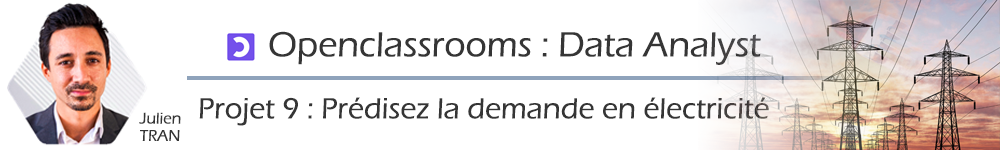

### Mission 3 : Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

### Sommaire // Mission 3

* [1.Importation des librairies et parametres df](#1)
* [2.Importation des fichiers CSV](#2)
* [3.Prédiction par Holt Winters](#3)
    * [3.1.Evaluation du modèle](#3.1)
* [4.Prédiction par Sarima](#4)
    * [4.1.Evaluation du modèle](#4.1)

## 1.Importation des librairies et parametres df <a class="anchor" id="1"></a>

In [1]:
#j'importe les librairies qui vont me servir plus tard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
import seaborn as sns
from matplotlib.pyplot import figure
import itertools

from statsmodels.tsa.api import ExponentialSmoothing #methode Holt Winter
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import *

import warnings

#Je definis le nombre de lignes max affichées sur None
pd.set_option("max_rows", None) 
pd.set_option("display.precision",7)

## 2.Importation des fichiers CSV <a class="anchor" id="2"></a>

In [2]:
#Je charge tous les fichiers csv
data_p9_corr = pd.read_csv("D:/DA_P9/NEW/data_p9_corr.csv")
data_conso = pd.read_csv("D:/DA_P9/NEW/12052022/data_conso.csv")

#J'affiche une phrase si l'import est reussi
print("Fichiers chargés avec succes!")

Fichiers chargés avec succes!


In [3]:
#Je check les 5 premieres lignes de mon df
data_p9_corr.head()

,Date,Conso_corr
0,2010-01-01,30705.2095044
1,2010-02-01,28881.3119936
2,2010-03-01,31426.7237149
3,2010-04-01,27757.7642380
4,2010-05-01,28577.4625523


In [4]:
# Conversion de la colonne Date au format date
data_p9_corr['Date'] = pd.to_datetime(data_p9_corr['Date'],format = "%Y-%m")

In [5]:
# Je défini la premiere colonne comme index
data_p9_corr.set_index("Date", inplace = True)

In [6]:
data_conso.head()

,Date,Consommation totale
0,2010-01-01,56342.0
1,2010-02-01,48698.0
2,2010-03-01,48294.0
3,2010-04-01,38637.0
4,2010-05-01,37284.0


In [7]:
#Je check le nombre de ligne et colonne
data_conso.shape

(143, 2)

In [8]:
# Conversion de la colonne Date au format date
data_conso['Date'] = pd.to_datetime(data_conso['Date'],format = "%Y-%m")

In [9]:
# Je défini la premiere colonne comme index
data_conso.set_index("Date", inplace = True)

In [10]:
# Suppression des lignes pour l'année 2021
#data_conso.drop([0, 0], axis=0, inplace=True)
data_conso.drop(data_conso.index[133:143],0,inplace=True)

## 3.Prédiction par Holt Winters <a class="anchor" id="3"></a>

### <font color='steelblue'> On commence par définir les paramètres de notre modèle puis on le représente graphiquement. Ici les paramètres de notre modèle contiennent des informations sur la saisonnalité qui est égale à 12 mois et une tendance et une saisonnalité additives. </font>

In [11]:
# Prévision à 12 mois par Holt-Winters de la conso corrigée

warnings.filterwarnings('ignore') #Ignorer les avertissements Anaconda

y = np.asarray(data_p9_corr["Conso_corr"])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

In [12]:
# Prévision à 12 mois par Holt-Winters de la conso totale

y2 = np.asarray(data_conso["Consommation totale"])
hw2 = ExponentialSmoothing(y2, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred2 = hw2.forecast(12)

### <font color='steelblue'> Dans un modèle additif, on suppose que les 3 composantes : tendance, variations saisonnières et variations accidentelles sont indépendantes les unes des autres. </font>

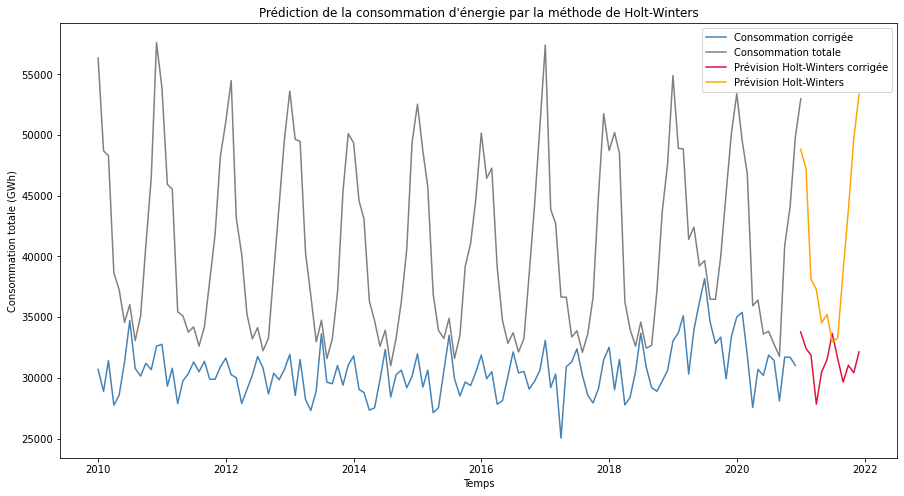

In [13]:
#Visualisation de la prévision à 12 mois par Holt-Winters de la conso corrigée et la consommation totale

plt.figure(figsize=(15,8))
plt.plot(data_p9_corr["Conso_corr"], label='Consommation corrigée',color="steelblue")
plt.plot(data_conso["Consommation totale"], label='Consommation totale',color="grey")

#Utilisation de pd.date_range pour selectionner la periode (12 mois) à prendre en compte pour la prévision souhaitée
plt.plot(pd.date_range(data_p9_corr.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters corrigée',color="crimson")
plt.plot(pd.date_range(data_conso.index[len(y)-1], periods=12, freq='M'), hw_pred2, label='Prévision Holt-Winters',color="orange")

plt.title("Prédiction de la consommation d\'énergie par la méthode de Holt-Winters")
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.legend(loc='best')
plt.show()

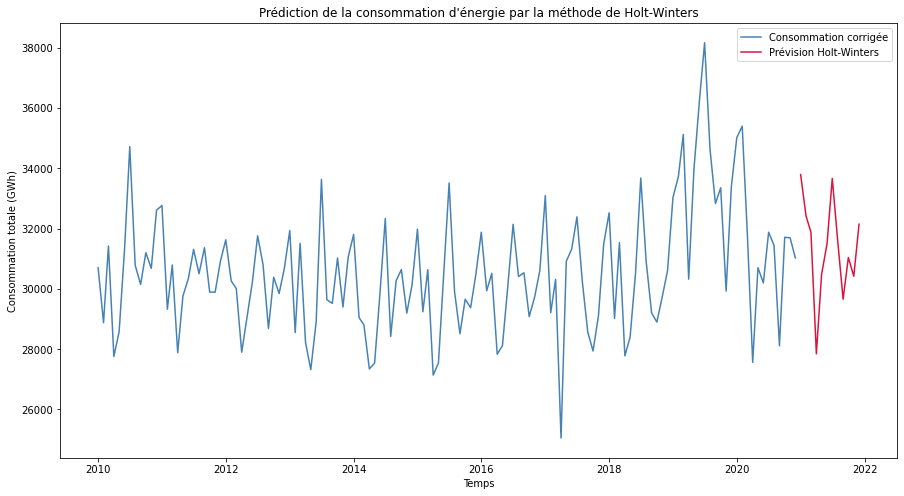

In [14]:
#Visualisation de la prévision à 12 mois par Holt-Winters de la conso corrigée

plt.figure(figsize=(15,8))
plt.plot(data_p9_corr["Conso_corr"], label='Consommation corrigée',color="steelblue")
plt.plot(pd.date_range(data_p9_corr.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters',color="crimson")

plt.title("Prédiction de la consommation d\'énergie par la méthode de Holt-Winters")
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.legend(loc='best')
plt.show()

## 3.1. Evaluation du modèle <a class="anchor" id="3.1"></a>

### <font color='steelblue'>  Pour évaluer mon modèle j'enlève les données des 12 derniers mois puis je compare les valeurs enregistrées (2020) avec les valeurs prédites de mon modèle. </font>

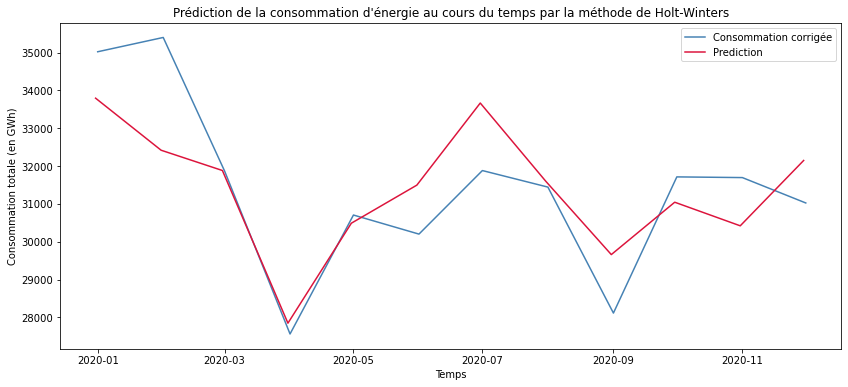

In [15]:
#Creation d'un dataframe avec les 12 derniers mois pour la prédiction
data_p9_corr_2 = data_p9_corr.drop(data_p9_corr.index[-12:])

hw3 = ExponentialSmoothing(np.asarray(data_p9_corr_2['Conso_corr']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred3 = hw3.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(data_p9_corr['Conso_corr'].iloc[-12:], label='Consommation corrigée', color='steelblue')
plt.plot(pd.date_range(data_p9_corr_2.index[len(data_p9_corr_2)-1], periods=12, freq='M'), hw_pred, label='Prediction', color='crimson')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

### <font color='steelblue'> Je calculer le MAPE (Mean Absolute Percentage) pour évaluer la qualité de ma prévision. L’erreur absolue moyenne est en pourcentage, c'est la moyenne des écarts en valeur absolue par rapport aux valeurs observées. </font>

In [16]:
#Calcul du MAPE
y_pred = hw_pred3
y_true = np.asarray(data_p9_corr_2['Conso_corr'].iloc[-12:])

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE = ', mape)

MAPE =  3.222556374935157


### <font color='steelblue'> Mon modèle obtient 3.22%, ce qui est plutôt bon. </font>

## 4.Prédiction par Sarima <a class="anchor" id="4"></a>

## Identification de la saisonnalité

### <font color='steelblue'> Pour contrer le problème de la difficulté de traitement de la présence d'une tendance et/ou d'une saisonnalité changeante, on va pouvoir utiliser un modèle issu de la méthode SARIMA. Cette méthode combine une méthode auto-regressive à une méthode de moyenne mobile. Cependant, on va devoir vérifier la non-stationnarité de notre série temporelle avant de pouvoir la réaliser. </font>

### <font color='steelblue'> Nous sommes en présence d'une série temporelle marquée par une forte saisonnalité, très classique sur les températures climatiques. Il n'est pas possible de modéliser directement par un processus stationnaire, la stationnarisation du processus sera donc mise en oeuvre. La méthode retenue sera la différenciation. </font>

### <font color='steelblue'> On commence donc par créer une variable qui ne contient que notre série temporelle de la consommation corrigée. </font>

In [17]:
y = data_p9_corr["Conso_corr"]

## Stationnarité et différenciation de la série

In [18]:
# Création d'une fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(17, 10), style='bmh'):
    """
    Test de Dickey–Fuller
    avec Autocorrélogrammes ACF et PACF

    """
    if not isinstance(y, pd.Series): # Check si un chiffre est un entier
        y = pd.Series(y)

    with plt.style.context(style): # Définition du style des viz
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1] # Affichage de la P-value au test de Dickey-Fuller
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax) # Plot de l'ACF
        sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)  # Plot de l'ACF partiel
        plt.tight_layout()

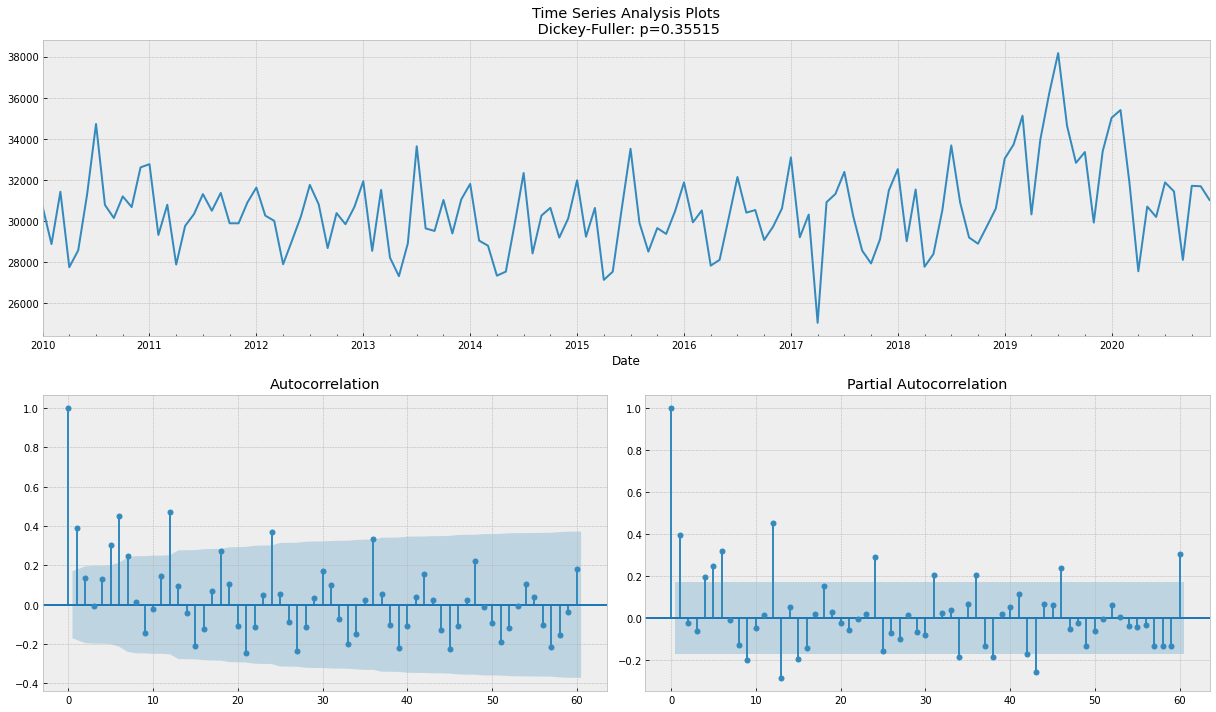

In [19]:
#Test de Dickey–Fuller avec Autocorrélogrammes ACF et PACF
tsplot(y, lags=60)

### <font color='steelblue'>La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. </font>


Hypothèse nulle (H0) : La consommation totale corrigée est issue d'une racine unitaire, elle est donc non stationnaire.(p>5%)  
Hypothèse alternative (H1) : La consommation totale corrigée n'est pas issue d'une racine unitaire, elle est donc stationnaire.(p<5%)

### <font color='steelblue'>La p-value est supérieure à p > 0.05 au test de Dickey-Fuller. On ne peut donc pas rejeter l'hypothèse nulle. La consommation totale corrigée est issue d'une racine unitaire et est non stationnaire. </font>

On effectue donc une première différenciation

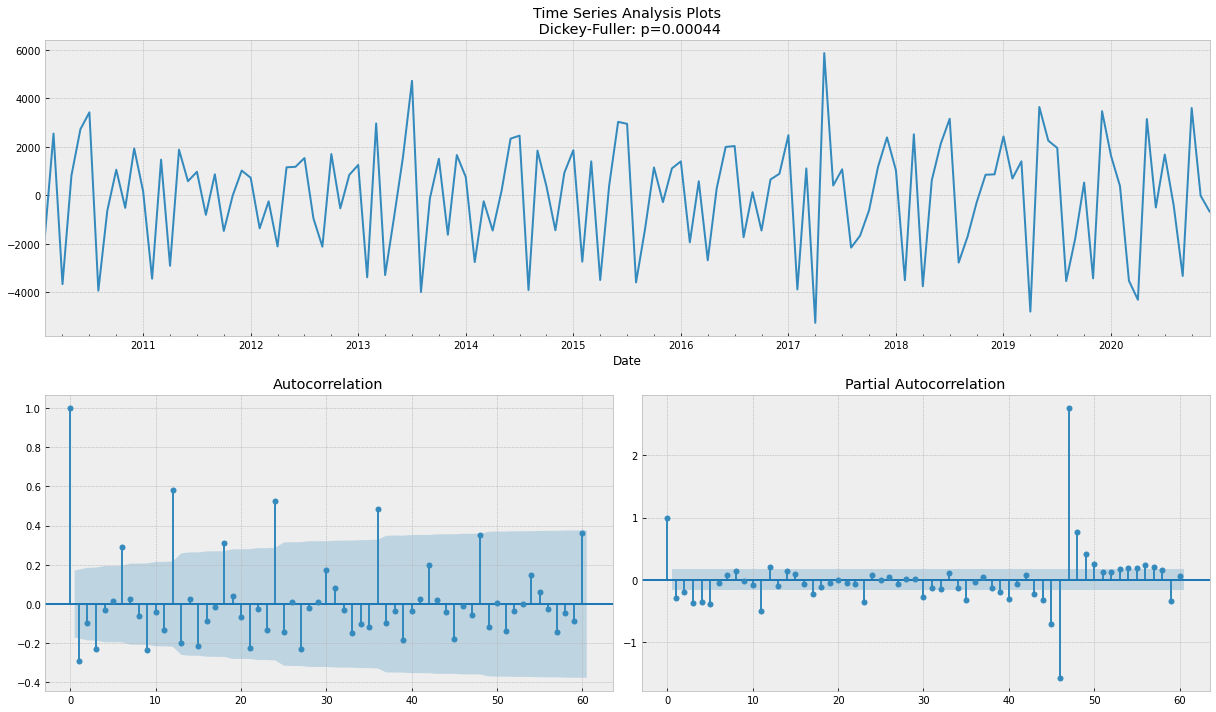

In [20]:
#Première différenciation d'ordre 1 par la méthode .shift()
y_dif1 = y - y.shift(1)
tsplot(y_dif1[1:], lags=60)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

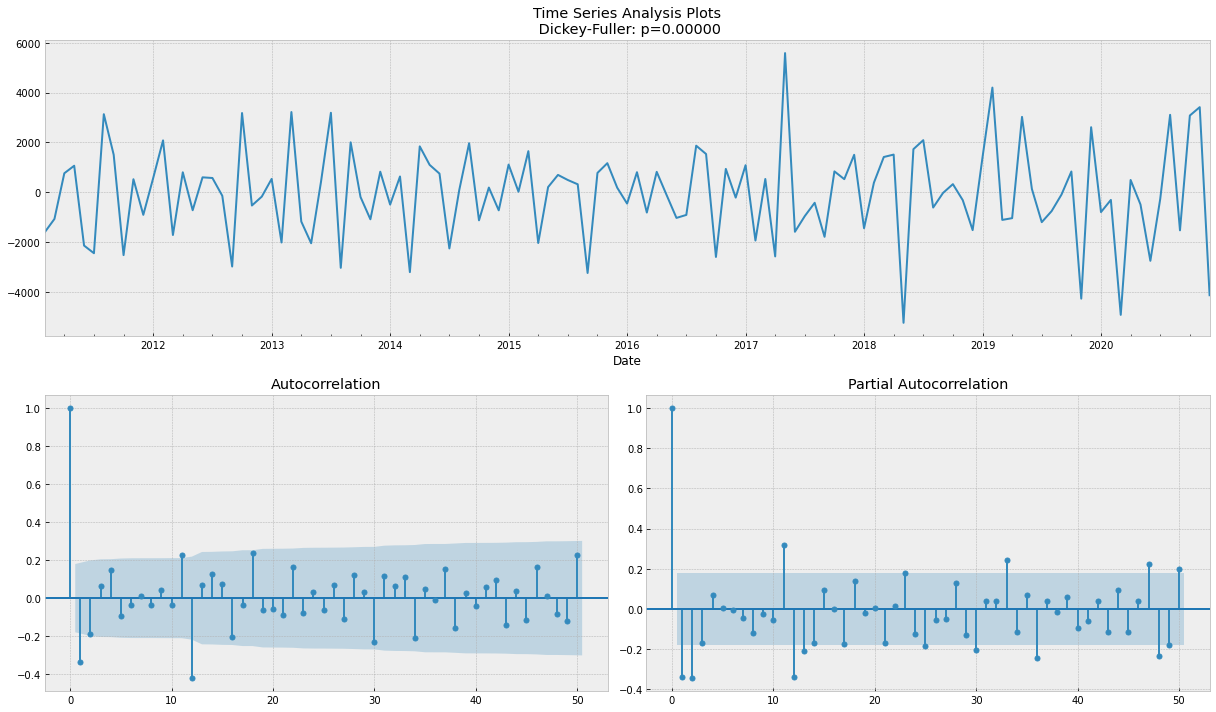

In [21]:
#Seconde différenciation d'ordre 12 par la méthode .shift()
y_dif2 = y_dif1 - y_dif1.shift(12)
tsplot(y_dif2[13:], lags=50)

Cette fois-ci les résultats sont satisfaisants, nous pouvons nous appuyer sur les autocorrélogrammes simple et partiels estimés.

## Génération d'une configuration optimale SARIMA

On détermine les meilleures paramètres de notre modèle SARIMA en utilisant une méthode de test automatisée se basant sur l'AIC et le BIC.

In [22]:
# Fonction affichant les 5 premières meilleurs combinaisaons de paramètres SARIMA
# En fonction de l'AIC et du BIC
def sarimax_gridsearch(ts, pdq, pdqs):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(ts,order=comb, seasonal_order=combs)
                output = mod.fit() 
                ans.append([comb, combs, output.bic, output.aic])
                #print('SARIMAX {} x {}12 : BIC Calculated ={} ; AIC Calculated : {}'.format(comb, combs, output.bic, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic', 'aic'],ascending=True)
    
    return ans_df.head()

In [23]:
%%time

# On attribue des valeurs comprises entre 0 et 3 (exclus) pour p, q et d.
p = d = q = range(0, 3)

# On génère toutes les combinaisons possibles avec p, q et d
pdq = list(itertools.product(p, d, q))

# On fait la même chose pour trouver les paramètres P, Q et D
# On fixe la valeur de s à 12 car on la déterminait auparavant
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# On utilise la fonction de gridsearch
sarimax_gridsearch(y, pdq, pdqs)

Wall time: 13min 3s


,pdq,pdqs,bic,aic
116,"(0, 1, 1)","(0, 2, 2, 12)",1918.7744457,1908.0831304
124,"(0, 1, 1)","(1, 2, 1, 12)",1920.5999680,1909.9086526
332,"(1, 1, 0)","(0, 2, 2, 12)",1921.9640333,1911.2727179
575,"(2, 1, 0)","(0, 2, 2, 12)",1922.3315602,1908.9674160
133,"(0, 1, 1)","(2, 2, 1, 12)",1922.7139439,1909.3497998


Les paramètres les plus adaptés à notre modèle sont (0, 1, 1) et (0, 2, 2, 12). On va donc construire notre modèle sur ces paramètres et faire nos prédictions à partir de cela.

## Définition du modèle

In [24]:
model = SARIMAX(y, order=(0, 1 ,1), seasonal_order = (0,2,2, 12))
results = model.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Conso_corr   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -950.042
Date:                                 Mon, 23 May 2022   AIC                           1908.083
Time:                                         13:38:01   BIC                           1918.774
Sample:                                     01-01-2010   HQIC                          1912.417
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3781      0.093     -4.066      0.000      -0.560      -0

## Evaluation du modèle et prédiction

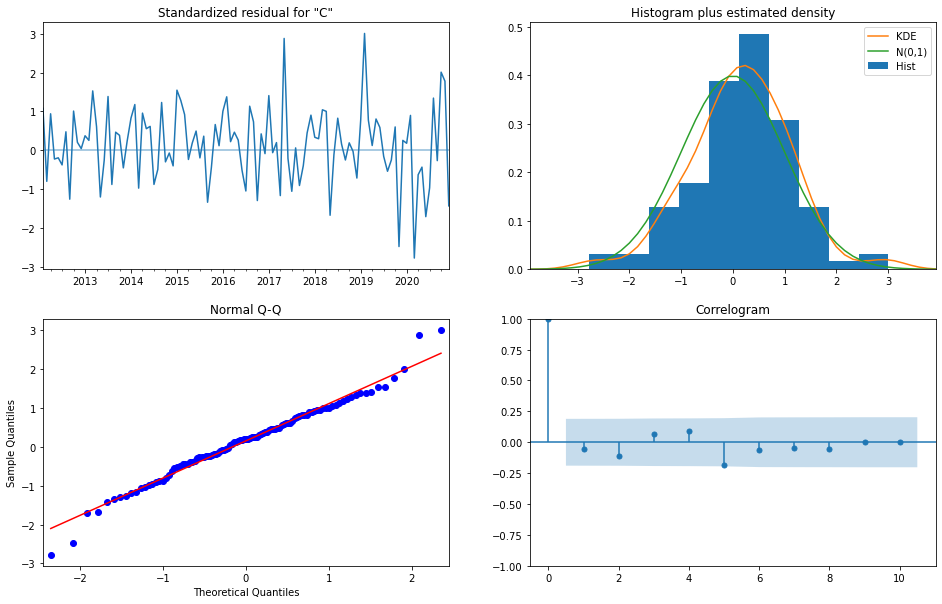

In [25]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
results.plot_diagnostics(figsize=(16,10));

In [26]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.5148719549179077, pvalue=4.934190773509572e-19)

### <font color='steelblue'> La distribution de nos résidus semble suivre une loi normale. On vérifie cela avec un test de Shapiro-Wilk se basant sur les hypothèses suivantes : </font>

H0 : Il est peu probable que la distribution de nos résidus suive une loi normale.(p>5%)  
H1 : Il est probable que la distribution de nos résidus suive une loi normale.(p<5%)

### <font color='steelblue'> La p-value est inférieure à 0.05. On peut donc rejeter l'hypothèse H0 selon laquelle il est peu probable que la distribution de nos résidus suive un loi normale. </font>

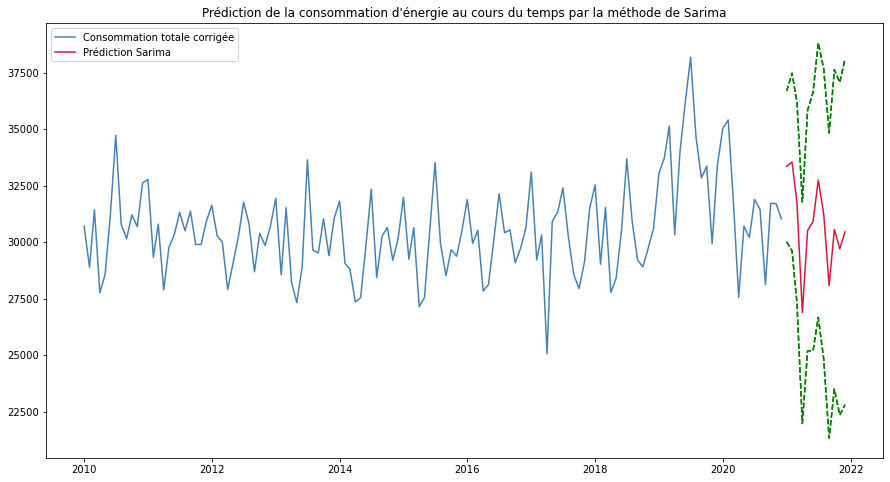

In [34]:
pred_model1 = results.get_forecast(12)
pred = pred_model1.predicted_mean
pred_l = pred_model1.conf_int(alpha=0.05)
pred_u = pred_model1.conf_int(alpha=0.05)

plt.figure(figsize=(15,8))
plt.plot(y, label='Consommation totale corrigée',color='steelblue')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred, color='crimson', label='Prédiction Sarima')
plt.plot(pd.date_range(y.index[len(data_p9_corr)-1], periods=12, freq='M'), pred_l, color='green', linestyle='--')
plt.plot(pd.date_range(y.index[len(data_p9_corr)-1], periods=12, freq='M'), pred_u, color='green', linestyle='--')
plt.legend(loc='best')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Sarima')
plt.show()

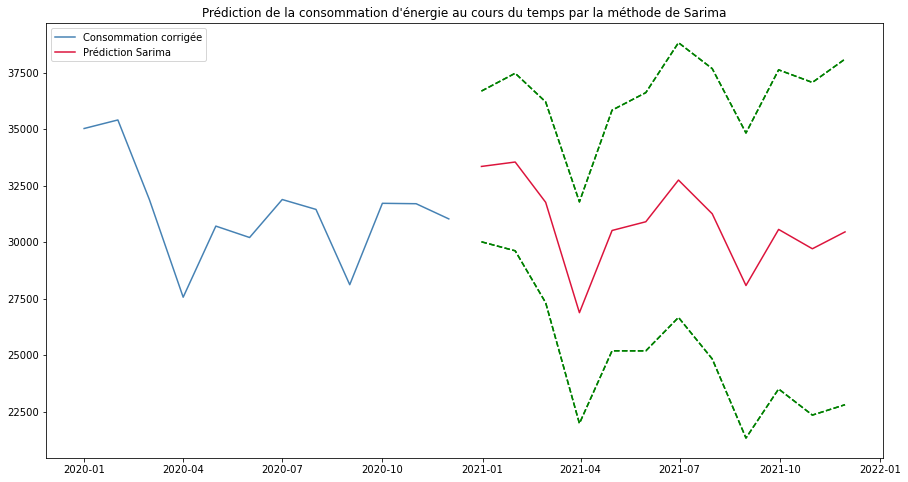

In [35]:
plt.figure(figsize=(15,8))
plt.plot(data_p9_corr['Conso_corr'].iloc[-12:], label='Consommation corrigée', color='steelblue')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), pred, color='crimson', label='Prédiction Sarima')
plt.plot(pd.date_range(y.index[len(data_p9_corr)-1], periods=12, freq='M'), pred_l, color='green', linestyle='--')
plt.plot(pd.date_range(y.index[len(data_p9_corr)-1], periods=12, freq='M'), pred_u, color='green', linestyle='--')
plt.legend(loc='best')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Sarima')
plt.show()

## 4.1. Evaluation du modèle <a class="anchor" id="4.1"></a>

Une fois la prédiction réalisée sur les 12 prochains mois, on va tester notre modèle. Pour cela, on lui demande de faire une prédiction sur des données déjà connues (les 12 mois que l'on connait, c'est-à-dire juin 2019 à mai 2020).

In [28]:
#On reprend le dataframe utilisée pour l'évalutation du modele précédent (data_p9_corr_2)
model_eval = SARIMAX(data_p9_corr_2, order=(0, 1 ,1), seasonal_order = (0,2,2, 12))
results_eval = model_eval.fit()
print(results_eval.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Conso_corr   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -837.198
Date:                                 Mon, 23 May 2022   AIC                           1682.396
Time:                                         13:38:04   BIC                           1692.611
Sample:                                     01-01-2010   HQIC                          1686.524
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4024      0.101     -3.998      0.000      -0.600      -0

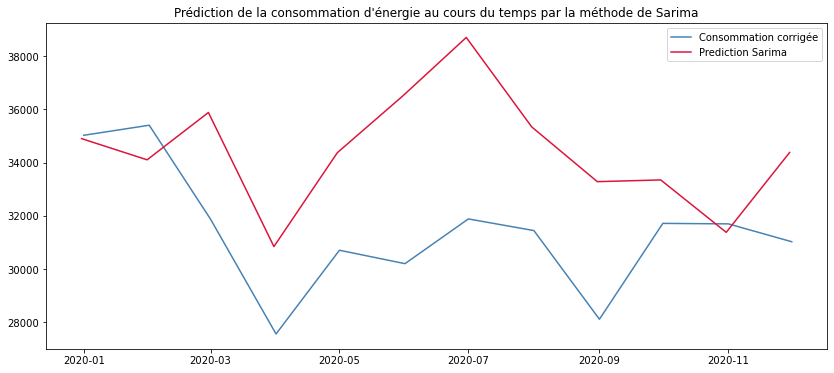

In [29]:
#Troncature des données sur les années 2017 et 2018
pred_model_eval = results_eval.get_forecast(12)
pred_eval = pred_model_eval.predicted_mean

plt.figure(figsize=(14,6))
plt.plot(data_p9_corr["Conso_corr"].iloc[-12:], label='Consommation corrigée', color='steelblue')
plt.plot(pd.date_range(data_p9_corr_2.index[len(data_p9_corr_2)-1], periods=12, freq='M'), pred_eval, label='Prediction Sarima', color='crimson')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Sarima')
plt.legend(loc='best')
plt.show()

### <font color='steelblue'> Par les chiffres nous pouvons calculer le MAPE (Mean Absolute Percentage). L’erreur absolue moyenne en pourcentage, en d'autres termes la moyenne des écarts en valeur absolue par rapport aux valeurs observées. </font>

In [30]:
#Calcul du MAPE
y_pred = pred_eval
y_true = np.asarray(data_p9_corr_2['Conso_corr'].iloc[-12:])

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE = ', mape)

MAPE =  2.0987705511619565


### <font color='steelblue'> Notre modèle obtient des scores plutôt bons avec une marge d'erreur (MAPE) de 2.1%, ce qui est en dessous du modele Holt Winters. </font>